In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [193]:
random.seed(3888)

In [194]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_52.csv")

In [195]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)

    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
        .transform(lambda x: np.sqrt(
            ((x.shift(1) ** 2)
                .rolling(30, min_periods=1)
                .sum()
            ).clip(lower=0)
        ))
    )

    # TARGET
    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-30)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna()   
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [196]:
df = make_features(df)

In [197]:
def add_time_features(df_enriched: pd.DataFrame, period: int = 600):

    theta = 2 * np.pi * df_enriched['seconds_in_bucket'] / period
    df_enriched['sec_sin'] = np.sin(theta)
    df_enriched['sec_cos'] = np.cos(theta)

    return df_enriched.drop(columns=["seconds_in_bucket"])

df = add_time_features(df)

In [198]:
for c in ['bid_size1','ask_size1','bid_size2','ask_size2']:
    df[c + '_log'] = np.log1p(df[c])
    df.drop(columns=c, inplace=True)

In [199]:
feature_cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',
       'stock_id', 'mid_price', 'spread', 'imbalance', 'book_pressure',
       'microprice', 'normalized_spread', 'OBI_L2', 'LOB_entropy',
       'LOB_entropy_normalized', 'log_return', 'realized_volatility', 'bipower_var', 'wap', 'log_wap_return', 'imbalance_lag1',
       'imbalance_lag2', 'book_pressure_lag1', 'book_pressure_lag2',
       'log_return_lag1', 'log_return_lag2', 'rolling_vol_30',
       'rolling_imbalance_mean_30', 'sec_sin', 'sec_cos', 'bid_size1_log',
       'ask_size1_log', 'bid_size2_log', 'ask_size2_log']
target_col = "rv_future"

In [200]:
df['rv_future_log'] = np.log1p(df['rv_future'])
feature_cols_mod = [c for c in feature_cols if c!='rv_future'] 
target_col_mod     = 'rv_future_log'

In [201]:
unique_sessions = df["time_id"].sort_values().unique()
split_idx       = int(len(unique_sessions) * 0.8)          
train_sessions  = unique_sessions[:split_idx]
test_sessions   = unique_sessions[split_idx:]

In [202]:
train_df = df[df["time_id"].isin(train_sessions)].copy()
test_df  = df[df["time_id"].isin(test_sessions)].copy()

In [203]:
x_scaler = MinMaxScaler().fit(train_df[feature_cols_mod])
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(train_df[[target_col_mod]])

train_df[feature_cols_mod] = x_scaler.transform(train_df[feature_cols_mod])
test_df[feature_cols_mod]  = x_scaler.transform(test_df[feature_cols_mod])
train_df[target_col_mod]   = y_scaler.transform(train_df[[target_col_mod]])
test_df[target_col_mod]    = y_scaler.transform(test_df[[target_col_mod]])

In [204]:
SEQ_LEN = 30   

def build_sequences(df_part: pd.DataFrame, feature_cols, target_col, seq_len):
    """Return X, y arrays where each sample is wholly inside one session."""
    X, y = [], []
    for _, session in df_part.groupby("time_id"):
        data   = session[feature_cols].values
        target = session[target_col].values
        for i in range(len(session) - seq_len):
            X.append(data[i : i + seq_len])
            y.append(target[i + seq_len])
    return np.asarray(X), np.asarray(y)

X_train, y_train = build_sequences(train_df, feature_cols, target_col, SEQ_LEN)
X_test,  y_test  = build_sequences(test_df,  feature_cols, target_col, SEQ_LEN)

In [205]:
val_split_idx = int(len(train_sessions) * 0.9)
val_sessions  = train_sessions[val_split_idx:]
train_sessions= train_sessions[:val_split_idx]

val_df = train_df[train_df["time_id"].isin(val_sessions)]
train_df = train_df[train_df["time_id"].isin(train_sessions)]

X_train, y_train = build_sequences(train_df, feature_cols_mod, 'rv_future_log', SEQ_LEN)
X_val,   y_val   = build_sequences(val_df,   feature_cols_mod, 'rv_future_log', SEQ_LEN)
X_test,  y_test  = build_sequences(test_df,  feature_cols_mod, 'rv_future_log', SEQ_LEN)

In [206]:
def build_lstm_model(seq_len, num_features):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(seq_len, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  
    return model

NUM_FEATURES = X_train.shape[2]
model = build_lstm_model(SEQ_LEN, NUM_FEATURES)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae', 'mse']
)
model.summary()

/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/volt/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 30, 64)         │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,049 (148.63 KB)

 Trainable params: 38,049 (148.63 KB)

 Non-trainable params: 0 (0.00 B)

In [207]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12, # 50
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/12
8185/8185 ━━━━━━━━━━━━━━━━━━━━ 148s 18ms/step - loss: 0.0016 - mae: 0.0229 - mse: 0.0016 - val_loss: 4.2593e-04 - val_mae: 0.0117 - val_mse: 4.2593e-04
Epoch 2/12
8185/8185 ━━━━━━━━━━━━━━━━━━━━ 145s 18ms/step - loss: 4.1782e-04 - mae: 0.0123 - mse: 4.1782e-04 - val_loss: 4.2011e-04 - val_mae: 0.0116 - val_mse: 4.2011e-04
Epoch 3/12
8185/8185 ━━━━━━━━━━━━━━━━━━━━ 146s 18ms/step - loss: 4.0351e-04 - mae: 0.0120 - mse: 4.0351e-04 - val_loss: 4.0035e-04 - val_mae: 0.0115 - val_mse: 4.0035e-04
Epoch 4/12
8185/8185 ━━━━━━━━━━━━━━━━━━━━ 146s 18ms/step - loss: 4.0140e-04 - mae: 0.0119 - mse: 4.0140e-04 - val_loss: 4.0683e-04 - val_mae: 0.0115 - val_mse: 4.0683e-04
Epoch 5/12
8185/8185 ━━━━━━━━━━━━━━━━━━━━ 147s 18ms/step - loss: 3.8636e-04 - mae: 0.0118 - mse: 3.8636e-04 - val_loss: 4.1060e-04 - val_mae: 0.0114 - val_mse: 4.1060e-04
Epoch 6/12
8185/8185 ━━━━━━━━━━━━━━━━━━━━ 151s 18ms/step - loss: 3.8446e-04 - mae: 0.0118 - mse: 3.8446e-04 - val_loss: 4.0190e-04 - val_mae: 0.0113 - va

In [208]:
pred_scaled = model.predict(X_test, verbose=1).flatten()
actual_scaled = y_test.flatten()
predictions = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actuals     = y_scaler.inverse_transform(actual_scaled.reshape(-1, 1)).flatten()

9041/9041 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


In [209]:
def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual,   eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(actuals, predictions)
mse   = np.mean((predictions - actuals) ** 2)
rmse  = np.sqrt(mse)
r2 = r2_score(actuals, predictions)

print(f"Test RMSE (volatility): {rmse:.9f}")
print(f"R² score (σ prediction): {r2:.6f}")
print("QLIKE:", ql)

Test RMSE (volatility): 0.000292112
R² score (σ prediction): 0.712212
QLIKE: 0.061605708012749165


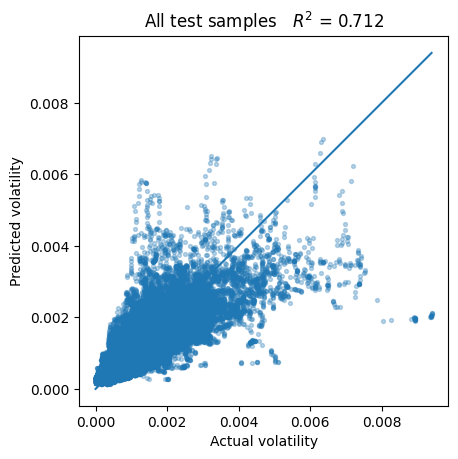

In [210]:
plt.figure()
plt.scatter(actuals, predictions, alpha=0.3, s=8)
lim = [min(actuals.min(), predictions.min()),
       max(actuals.max(), predictions.max())]
plt.plot(lim, lim)                     
plt.title(f"All test samples   $R^2$ = {r2_score(actuals, predictions):.3f}")
plt.xlabel("Actual volatility")
plt.ylabel("Predicted volatility")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

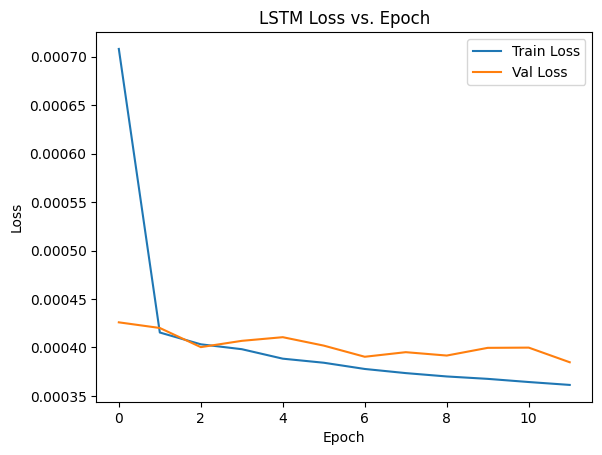

In [211]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

---

In [212]:
model_name_value = "Transformer" 
pred_related_stock_ids = []
pred_related_time_ids = []
original_test_df_for_ids = df[df["time_id"].isin(test_sessions)].copy()

for current_time_id_value in test_sessions:
    session_df_from_original = original_test_df_for_ids[original_test_df_for_ids["time_id"] == current_time_id_value]
    num_y_samples_in_session = len(session_df_from_original) - SEQ_LEN
    if num_y_samples_in_session > 0:
        stock_ids_for_session_targets = session_df_from_original['stock_id'].iloc[SEQ_LEN:].values.tolist()
        
        pred_related_stock_ids.extend(stock_ids_for_session_targets)
        pred_related_time_ids.extend([current_time_id_value] * num_y_samples_in_session)

if len(pred_related_stock_ids) != len(predictions):
    print(f"Warning: Length mismatch between reconstructed stock_ids ({len(pred_related_stock_ids)}) and predictions ({len(predictions)}).")

if len(pred_related_time_ids) != len(predictions):
    print(f"Warning: Length mismatch between reconstructed time_ids ({len(pred_related_time_ids)}) and predictions ({len(predictions)}).")

results_df = pd.DataFrame({
    'stock_id': pred_related_stock_ids,
    'time_id': pred_related_time_ids,
    'model_name': model_name_value,
    'mse': mse,  
    'qlike': ql, 
    'r^2': r2,  
    'pred_vol': predictions,
    'true_vol': actuals
})

output_csv_filename = f"{pred_related_stock_ids[0]}.csv"
results_df.to_csv(output_csv_filename, index=False)

print(f"Model findings saved to {output_csv_filename}")

Model findings saved to 52.csv
